In [80]:
import numpy as np

In [81]:
import pandas as pd

In [82]:
import math

In [83]:
from tensorflow import keras
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

In [84]:
from keras import layers

In [85]:
pd.options.display.max_columns = 20

In [86]:
df = pd.read_csv("vni_data.csv", parse_dates=[0])
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2022-08-17,"1,279.98","1,274.69","1,280.61","1,274.69",457.59K,0.42%
1,2022-08-16,"1,274.69","1,274.20","1,275.93","1,271.11",617.72K,0.04%
2,2022-08-15,"1,274.20","1,262.33","1,274.24","1,262.33",634.20K,0.94%
3,2022-08-12,"1,262.33","1,252.07","1,262.33","1,248.65",542.04K,0.82%
4,2022-08-11,"1,252.07","1,256.50","1,268.03","1,245.85",810.55K,-0.35%


In [87]:
df['Price']=df['Price'].apply(lambda x: float(x.split()[0].replace(',', ''))).astype(float)
df['Open']=df['Open'].apply(lambda x: float(x.split()[0].replace(',', ''))).astype(float)
df['High']=df['High'].apply(lambda x: float(x.split()[0].replace(',', ''))).astype(float)
df['Low']=df['Low'].apply(lambda x: float(x.split()[0].replace(',', ''))).astype(float)
df['Vol.']=df['Vol.'].apply(lambda x: int(float(x[:-1])*1000)).astype(int)

In [88]:
df.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                 int32
Change %            object
dtype: object

In [89]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2022-08-17,1279.98,1274.69,1280.61,1274.69,457590,0.42%
1,2022-08-16,1274.69,1274.20,1275.93,1271.11,617720,0.04%
2,2022-08-15,1274.20,1262.33,1274.24,1262.33,634200,0.94%
3,2022-08-12,1262.33,1252.07,1262.33,1248.65,542040,0.82%
4,2022-08-11,1252.07,1256.50,1268.03,1245.85,810550,-0.35%


In [90]:
import matplotlib.pyplot as plt

In [91]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

<AxesSubplot:xlabel='Date'>

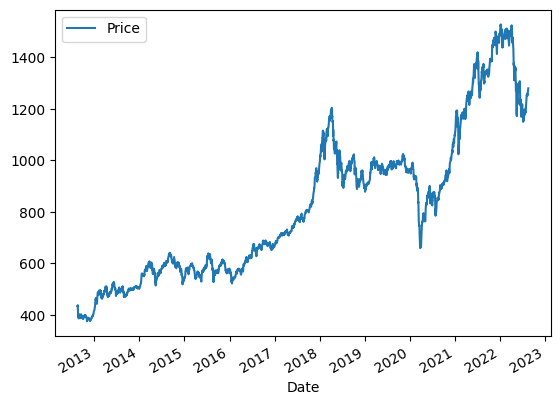

In [92]:
df.plot(x='Date', y='Price')

In [93]:
# data preprocessing
cprice_values = df['Price'].values
training_data_len = math.ceil(len(cprice_values)*0.8)

In [94]:
scaler = MinMaxScaler(feature_range=(0,1))
# transform into 2D array (n rows, 1 column)
scaled_data = scaler.fit_transform(cprice_values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

In [95]:
# put stuff into here
x_train = []
y_train = []

In [96]:
# create windows for sequential training:
# first 60 days as feature (x)
# the 61st day as label (y)
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
# convert to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# for a LSTM model, convert x_train into a 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [97]:
# training data include the -60 days for the first few values in y test
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = np.array(scaled_data[training_data_len:])

for i in range(60, len(test_data)):
    # leave out the last date for y (since y > any x)
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [98]:
# make sure that x and y has equal lengths
print(x_train.shape[0] == y_train.shape[0])

True


In [99]:
x_train.shape

(1937, 60, 1)

In [100]:
print(x_test.shape[0] == y_test.shape[0])

True


In [134]:
def build_model(x, y):
    # build model
    model = Sequential()

    # the input is multiple nodes, with each node contain 90 days' worth of data (hence the shape)
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1],1)))
    
    # add another layer ?
    model.add(layers.LSTM(100, return_sequences=True, dropout=0.2))
    # add another LSTM layer
    model.add(layers.LSTM(100, return_sequences=False, dropout=0.2))
    
    # add densely connected layers
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    
    # show summary of the architecture
    model.summary()
    
    # batch size is the number of samples used to train before the model is updated
    # epochs is when an entire dataset is passed forward and backward through the network once
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    model.fit(x, y, batch_size=10, epochs=5)
    return model

In [135]:
model = build_model(x_train, y_train)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_33 (LSTM)              (None, 60, 100)           80400     
                                                                 
 lstm_34 (LSTM)              (None, 100)               80400     
                                                                 
 dense_24 (Dense)            (None, 25)                2525      
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 204,151
Trainable params: 204,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
194/194 [============================

In [136]:
# model evaluation
predictions = model.predict(x_test)

16/16 [==============================] - 6s 208ms/step


In [137]:
# denormalize the predicted stock prices
predictions = scaler.inverse_transform(predictions)
# apply the rmse (root mean squared error) to calculate the degree of discrepancy
rmse = np.sqrt(np.mean(predictions - y_test)**2)

In [138]:
np.mean(predictions - y_test)

503.90198116155733

C:\Users\User\AppData\Local\Temp\ipykernel_38008\2420924013.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


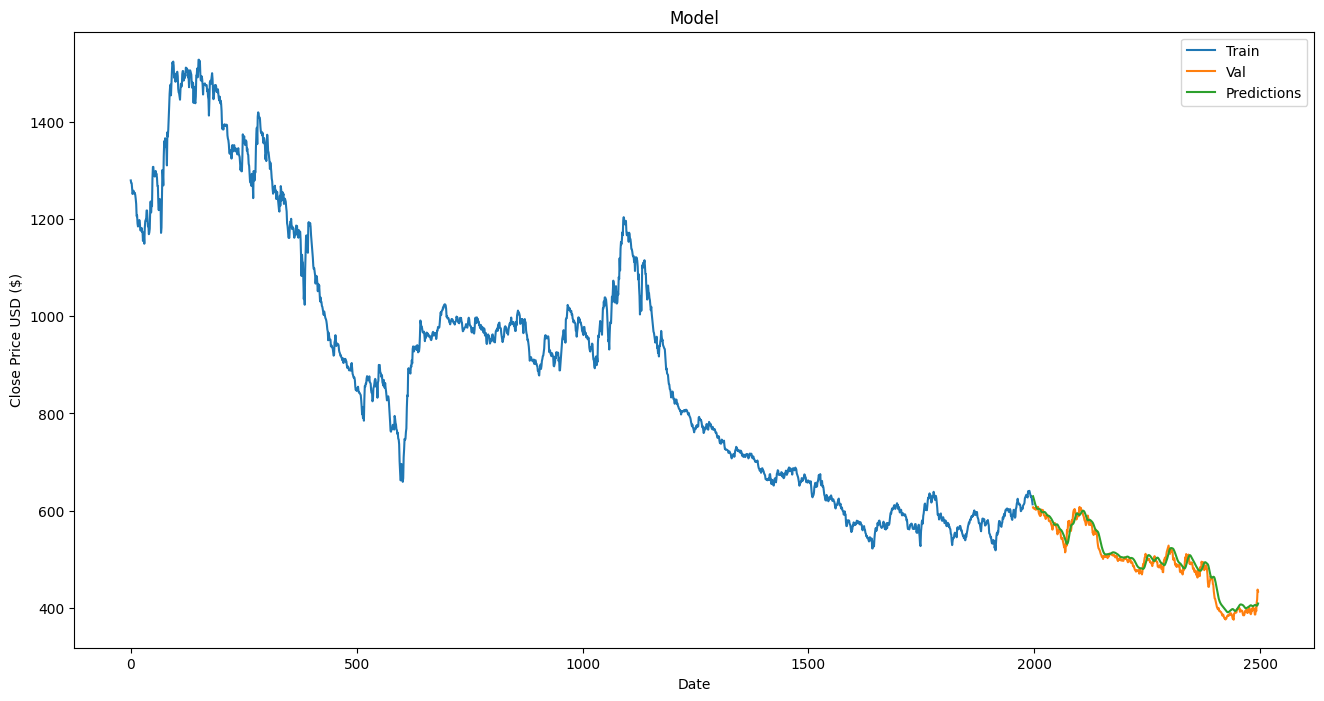

In [139]:
data = df.filter(['Price'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()